In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
covid_confirmed = pd.read_csv("/Users/listar/Desktop/Spring 2020/data100-final/final_proj_data/covid19/time_series_covid19_confirmed_US.csv")

In [20]:
covid_confirmed['Long_']

0      -170.1320
1       144.7937
2       145.6739
3       -66.5901
4       -64.8963
          ...   
3250      0.0000
3251      0.0000
3252      0.0000
3253      0.0000
3254      0.0000
Name: Long_, Length: 3255, dtype: float64

In [3]:
covid_valid_loc = covid_confirmed[(covid_confirmed['Lat'] != 0) & (covid_confirmed['Long_'] != 0)][['Lat', 'Long_', '4/18/20']]
covid_valid_loc

,Lat,Long_,4/18/20
0,-14.271000,-170.132000,0
1,13.444300,144.793700,136
2,15.097900,145.673900,14
3,18.220800,-66.590100,1118
4,18.335800,-64.896300,53
...,...,...,...
3144,41.287818,-110.547578,6
3145,43.904516,-107.680187,5
3146,43.839612,-104.567488,0
3147,41.406747,-70.687635,23


Text(0, 0.5, 'latitude')

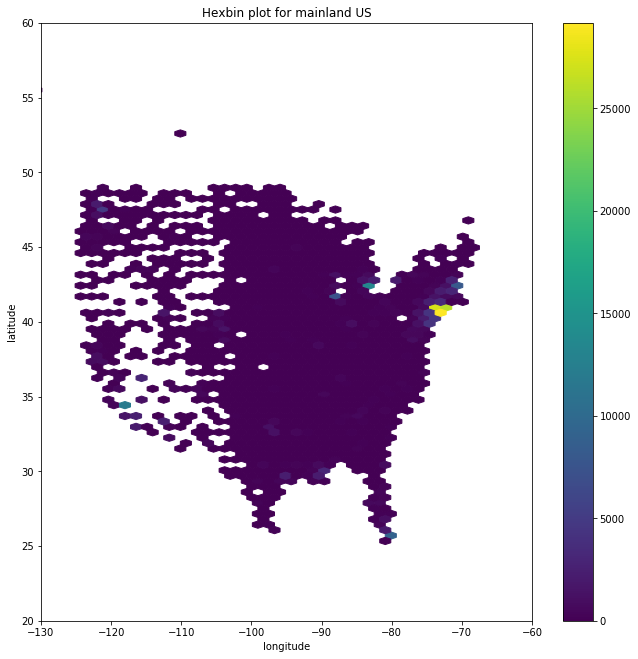

In [75]:
map_bound = (-130, -60, 20, 60)

fig, ax = plt.subplots(figsize = (11,11))
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])

plt.hexbin(covid_valid_loc['Long_'], covid_valid_loc['Lat'], C=covid_valid_loc['4/18/20'], reduce_C_function=np.mean, gridsize=200)
bar = plt.colorbar()
plt.title("Hexbin plot for mainland US")
plt.xlabel("longitude")
plt.ylabel("latitude")


In [60]:
covid_valid_loc[covid_valid_loc['4/18/20'] < 1]

,Lat,Long_,4/18/20
0,-14.271000,-170.132000,0
72,55.322224,-161.972202,0
73,52.725411,-110.408643,0
76,58.745140,-156.701064,0
77,63.672640,-150.007611,0
...,...,...,...
3098,44.583074,-91.999496,0
3112,45.211793,-90.500440,0
3114,43.594227,-90.832469,0
3139,42.132991,-104.966331,0


Text(0, 0.5, 'latitude')

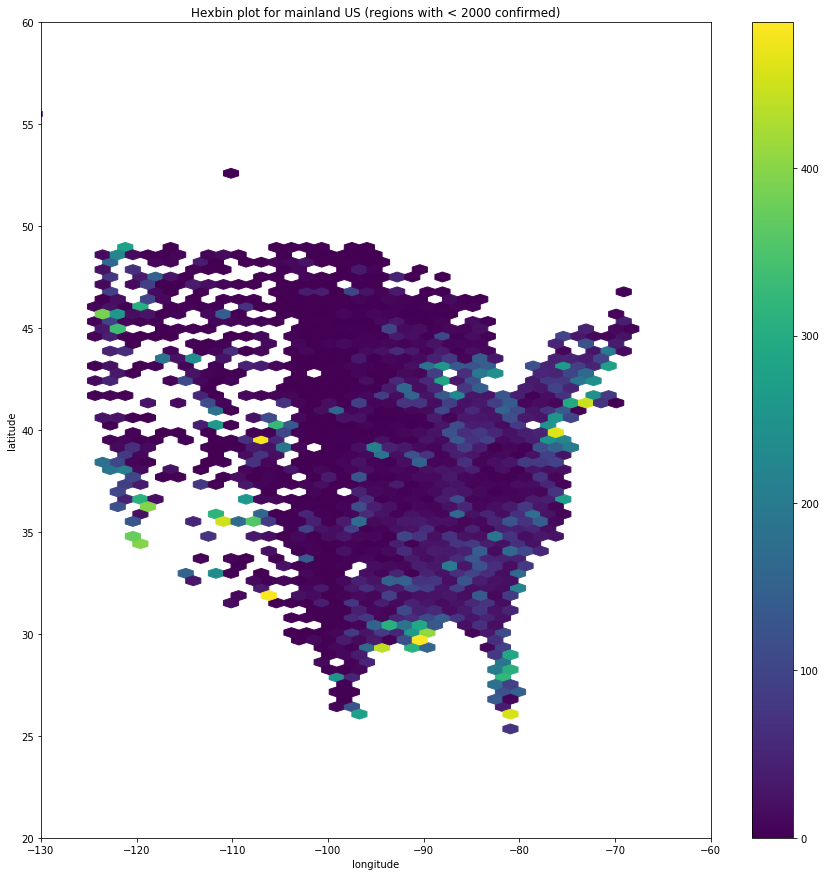

In [55]:
covid_valid_loc2 = covid_valid_loc[covid_valid_loc['4/18/20'] < 500]

fig, ax = plt.subplots(figsize = (15,15))
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])

plt.hexbin(covid_valid_loc2['Long_'], covid_valid_loc2['Lat'], C=covid_valid_loc2['4/18/20'], reduce_C_function=np.mean, gridsize=200)
bar = plt.colorbar()
plt.title("Hexbin plot for mainland US (regions with < 2000 confirmed)")
plt.xlabel("longitude")
plt.ylabel("latitude")

## Baseline Regression/Classification Algorithms

In [35]:
def mapper(x):
    if x > 10000:
        return "most severe"
    elif x > 5000:
        return "very severe"
    elif x > 1000:
        return "severe"
    elif x > 500:
        return "mild"
    elif x > 200:
        return "fine"
    else:
        return "ok"

import string

pertiles = [np.percentile(train_covid['4/18/20'], i * 10) for i in range(1, 10)]
letters = string.ascii_uppercase

def better_mapper(x):
    for j in range(9):
        if x <= pertiles[j]:
            return letters[j]
    return letters[8]

covid_valid_loc['status_new'] = covid_valid_loc['4/18/20'].apply(better_mapper)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [46]:
def dist_metric(loc1, loc2):
    lat1, lon1, lat2, lon2  = loc1[0], loc1[1], loc2[0], loc2[1]
    p = 0.017453292519943295 # Pi / 180
    a = 0.5 - np.cos((lat2 - lat1) * p) / 2 + np.cos(lat1 * p) * np.cos(lat2 * p) * \
    (1 - np.cos((lon2 - lon1) * p)) / 2
    return 12742 * np.arcsin(a ** 2) # 12742 = 2 * R

In [9]:
# test
lat1, lon1 = 32.10030533, -85.71265535
lat2, lon2 = 31.75300095, -86.68057478

dist_metric(lat1, lon1, lat2, lon2)

4.675820450994429e-05

In [10]:
lat3, lon3 = 32.0971334, -111.7890033 # somewhere in arizona
dist_metric(lat1, lon1, lat3, lon3)

16.998227063634047

## KNN algorithm for prediction

In [53]:
train_covid, test_covid = train_test_split(covid_valid_loc)

train_X, train_y = train_covid[['Lat', 'Long_']], train_covid['status_new']

knn_clf = KNeighborsClassifier(weights="distance", metric=dist_metric)

In [54]:
knn_clf.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
                     metric=<function dist_metric at 0x128756050>,
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [55]:
train_X['predicted'] = knn_clf.predict(train_X)

In [56]:
train_X

,Lat,Long_,predicted
147,35.742427,-91.570016,E
2273,41.992538,-80.033020,H
961,39.784438,-99.902866,A
1972,34.642445,-79.102505,G
1395,46.069962,-94.897853,C
...,...,...,...
1933,36.303375,-78.651842,I
1013,37.209462,-86.687488,H
88,62.313050,-149.574174,F
1593,36.654653,-93.040752,E


In [58]:
train_X['real'] = covid_valid_loc.iloc[train_X.index]['status_new']

In [60]:
np.sum(train_X['predicted'] == train_X['real'])

2361

In [61]:
len(train_X)

2361

In [63]:
test_X = test_covid[['Lat', 'Long_']]
test_covid['predicted'] = knn_clf.predict(test_X)

In [65]:
accuracy = np.sum(test_covid['status_new'] == test_covid['predicted']) / len(test_covid)

In [66]:
accuracy

0.27284263959390864

In [70]:
knn_clf2 = KNeighborsClassifier(metric=dist_metric)

knn_clf2.fit(train_covid[['Lat', 'Long_']], train_y)
test_covid['predicted2'] = knn_clf2.predict(test_X)

In [71]:
accuracy2 = np.sum(test_covid['status_new'] == test_covid['predicted2']) / len(test_covid)
accuracy2

0.27411167512690354

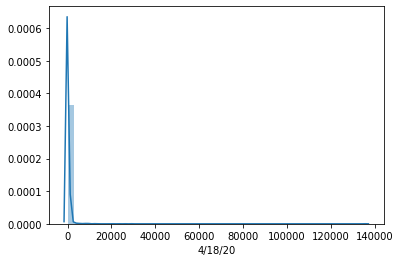

In [72]:
import seaborn as sns

sns.distplot(covid_valid_loc['4/18/20'])

In [73]:
covid_valid_loc['predicted'] = knn_clf2.predict(covid_valid_loc[['Lat', 'Long_']])

(20, 60)

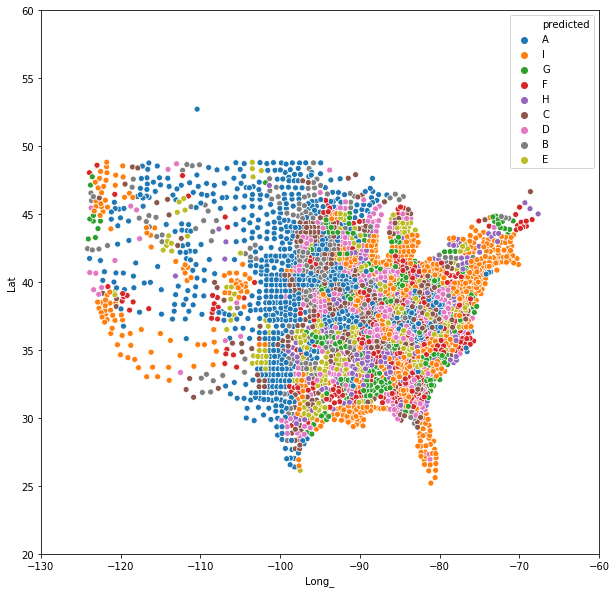

In [80]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot("Long_", "Lat", hue="predicted", data=covid_valid_loc)
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])

(20, 60)

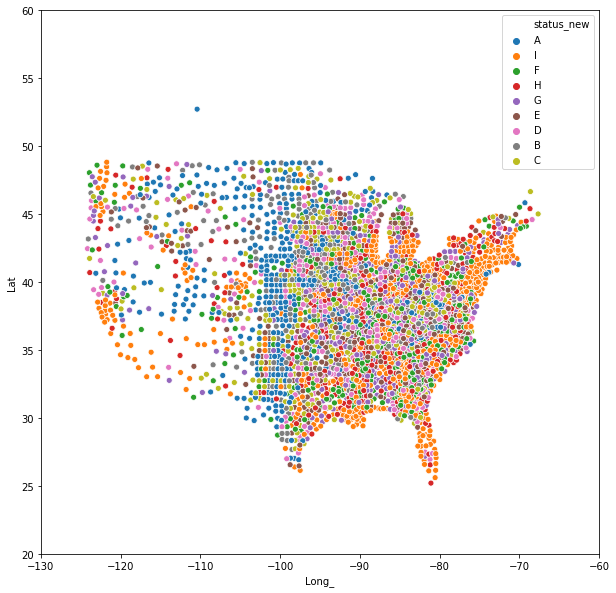

In [81]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot("Long_", "Lat", hue="status_new", data=covid_valid_loc)
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])